<a href="https://colab.research.google.com/github/chandan110791/Automatic_Ticket_Classification/blob/main/Automatic_Ticket_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 

# Objective
With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

# Solution structure

1. Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

  - Model training and evaluation

8. Model inference

9. Conclusions

## Importing the necessary libraries

In [ ]:
# A package which efficiently applies any function to a pandas dataframe or series in the fastest available manner
!pip install swifter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 830 kB 4.8 MB/s 
     |████████████████████████████████| 280 kB 73.2 MB/s 
     |████████████████████████████████| 1.6 MB 84.7 MB/s 
  Created wheel for swifter: filename=swifter-1.3.4-py3-none-any.whl size=16323 sha256=adde69a64e6a105301e5a405886364aa25401e6a08268282ffc9048721024d6d
  Stored in directory: /root/.cache/pip/wheels/29/a7/0e/3a8f17ac69d759e1e93647114bc9bdc95957e5b0cbfd405205
Successfully built swifter
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
import swifter

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from pprint import pprint

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

### NOTE: include below cell only when submitting so they can run notebook locally.

In [ ]:
# Opening JSON file 
#f = open('complaints-2021-05-14_08_16.json','r')  # Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
#data = json.load(f)
#df = pd.json_normalize(data)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp /content/gdrive/MyDrive/ML/DataSets/complaints-2021-05-14_08_16.json .

In [ ]:
# Opening JSON file from below location
# url : https://drive.google.com/file/d/1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K/view
# Write the path to your data file and load it
path = '/content/complaints-2021-05-14_08_16.json'
# Using open() function open a file with read mode, and returns it as a file object. 
f= open(path,"r")

# returns JSON object as a dictionary 
data = json.load(f)
df = pd.json_normalize(data)

## Data preparation

In [ ]:
# Inspect the dataframe to understand the given data.
df.head(2)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided


In [ ]:
df.shape

(78313, 22)

We have **78,313 rows** and **22 columns**.

We see **complaints details** are under column ***complaint_what_happened***.

JSON normalise method alters the columns' names, so we need to rename them.

In [ ]:
# Print the column names
list(df.columns)

['_index',
 '_type',
 '_id',
 '_score',
 '_source.tags',
 '_source.zip_code',
 '_source.complaint_id',
 '_source.issue',
 '_source.date_received',
 '_source.state',
 '_source.consumer_disputed',
 '_source.product',
 '_source.company_response',
 '_source.company',
 '_source.submitted_via',
 '_source.date_sent_to_company',
 '_source.company_public_response',
 '_source.sub_product',
 '_source.timely',
 '_source.complaint_what_happened',
 '_source.sub_issue',
 '_source.consumer_consent_provided']

In [ ]:
# Assign new column names
# 1. Delete initial underscore
df.columns = [re.sub('^_', '', col) for col in df.columns]

In [ ]:
# 2. Delete "source" word at beginning of some columns
df.columns = [re.sub('^source.', '', col) for col in df.columns]

We'll take a look at the columns' information.

In [ ]:
# View the info of all columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      78313 non-null  object 
 1   type                       78313 non-null  object 
 2   id                         78313 non-null  object 
 3   score                      78313 non-null  float64
 4   tags                       10900 non-null  object 
 5   zip_code                   71556 non-null  object 
 6   complaint_id               78313 non-null  object 
 7   issue                      78313 non-null  object 
 8   date_received              78313 non-null  object 
 9   state                      76322 non-null  object 
 10  consumer_disputed          78313 non-null  object 
 11  product                    78313 non-null  object 
 12  company_response           78313 non-null  object 
 13  company                    78313 non-null  obj

In [ ]:
# Inspect the number of missing values
df.isna().sum(0)

index                            0
type                             0
id                               0
score                            0
tags                         67413
zip_code                      6757
complaint_id                     0
issue                            0
date_received                    0
state                         1991
consumer_disputed                0
product                          0
company_response                 0
company                          0
submitted_via                    0
date_sent_to_company             0
company_public_response      78309
sub_product                  10571
timely                           0
complaint_what_happened          0
sub_issue                    46297
consumer_consent_provided     1008
dtype: int64

There are missing values in different columns. However, not all the columns will be required in model building, so we leave them untreated. 

We will **only use the column with complaint**, for which we'll check for string empy values.

In [ ]:
# Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace("", np.nan, inplace=True)

In [ ]:
# Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)

In [ ]:
# Confirm we do not have empty values
len(df[df['complaint_what_happened'] == ""])

0

In [ ]:
# Keep complaints column only
df = df[['complaint_what_happened']].reset_index(drop=True)
df.head(2)

,complaint_what_happened
0,Good morning my name is XXXX XXXX and I apprec...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...


After the cleaning, let's take a look into rows count.

In [ ]:
df.shape

(21072, 1)

We have **21,072 rows**.

From original 78,313 rows **we dropped ~73% of them** as we are only focusing on complaint analysis.

## Text preprocessing


 Let's **take a look at one complaint** to see what text formats we expect.

In [ ]:
df['complaint_what_happened'].iloc[395]

"Chase Card Address : XXXX XXXX XXXX City/ State/ Zip : XXXX, DE XXXX Date : XX/XX/XXXX Re : Acct # XXXX To Whom It May Concern : I have previously sent you a request to validate my debt under the Fair Debt Collection Practices Act and all I received was an itemized list of the alleged charges you claim I owe you. This does not meet the Federal Trade Commissions guidelines of what constitutes proper debt validation In addition, in the case of XXXX Vs. XXXX ( IN THE COURT OF APPEALS OF INDIANA, No. XXXX ), the court ruled that : 15 U.S.C. 1692g ( b ) ( emphasis added ). On XX/XX/XXXX, nineteen days after the date of XXXX debt collection letter, XXXX counsel XXXX sent XXXX a letter declaring that XXXX disputes your debt collection-related allegations, denies the same, and demands strict proof and verification thereof. Record at 21. As such, XXXX should have ceased his debt collection efforts immediately upon receiving that letter. Instead, XXXX proceeded to obtain a default judgment agai

### Clean texts

We see there are different **parts of the text to be cleaned**:
- Text within braces or square brackets
- Line breaks (\n)
- Punctuation
- Numerical values
- Words containing numbers
- Extra white spaces

And we'll be formatting **text to lowercase**.

In [ ]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_data(text):
    """
    This function takes a corpus of words (text) and returns the text in 
    lowercase without above specified scenarios
    :param text: input text
    :return: clean text
    """
    text = text.lower()                               # Text to lowercase
    text = re.sub(r'\(\w*\)', '', text)               # Remove text within braces
    text = re.sub(r'\s\{\$\S*', '',text)              # Remove text within curly braces
    text = re.sub(r'\s\[\$\S*', '',text)              # Remove text within square brackets
    text = re.sub(r'\n', '', text)                    # Remove line breaks
    text = re.sub(r'(\W\s)|(\W$)|(\W\d*)', ' ',text)  # Remove punctuation
    text = re.sub(r'\d+\s', '', text)                 # Remove numerical values
    text = re.sub(r'\w*\d\w*', '', text)              # Remove words that contain numbers
    text = re.sub(r' +', ' ',text)                    # Remove extra white spaces
    return text

Let's confirm we have cleaned the text, comparing with the one we checked above.

In [ ]:
clean_data(df['complaint_what_happened'].iloc[395])

'chase card address xxxx xxxx xxxx city state zip xxxx de xxxx date xx xx xxxx re acct xxxx to whom it may concern i have previously sent you a request to validate my debt under the fair debt collection practices act and all i received was an itemized list of the alleged charges you claim i owe you this does not meet the federal trade commissions guidelines of what constitutes proper debt validation in addition in the case of xxxx vs xxxx in the court of appeals of indiana no xxxx the court ruled that u s c b emphasis added on xx xx xxxx nineteen days after the date of xxxx debt collection letter xxxx counsel xxxx sent xxxx a letter declaring that xxxx disputes your debt collection related allegations denies the same and demands strict proof and verification thereof record at as such xxxx should have ceased his debt collection efforts immediately upon receiving that letter instead xxxx proceeded to obtain a default judgment against xxxx on the debt collection claim before he had mailed

Let's then save the cleaned dataframe.

In [ ]:
df['complaint_what_happened'] = df['complaint_what_happened'].apply(clean_data)

### Lemmatization

Now we'll **lemmatize the texts** and create a dataframe with cleaned complaints and their lemmatization.

In [ ]:
# Write your function to Lemmatize the texts
def lemmatization(text):
    """
    This function takes a corpus of words (text) and returns the lemmatized text
    :param text: input text
    :return: lemmatized text
    """
    tokens = word_tokenize(text)
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmatizer.lemmatize(token) for token in tokens]
    lemmatized = ' '.join(lemmatized)
    return lemmatized

In [ ]:
# Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame({'complaint':df['complaint_what_happened'], 'lemmatized':df['complaint_what_happened'].apply(lemmatization)})

In [ ]:
df_clean.head(2)

,complaint,lemmatized
0,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...
1,i upgraded my xxxx xxxx card in xx xx and was ...,i upgraded my xxxx xxxx card in xx xx and wa t...


### Keep nouns only

We'll extract the POS tags of the lemmatized text and remove all the words which have tags other than NN [tag == "NN"].

In [ ]:
# Function to extract the POS tags and keep the nouns only
def pos_tag(text):
    """
    This function takes a corpus of words (text) and returns only the words in 
    text that correspond to a noun
    :param text: input text
    :return: nouns from text
    """
    nouns = []
    doc = nlp(text)
    for token in doc:
        if(token.tag_ == 'NN'):
            nouns.append(token.lemma_)
    nouns = ' '.join(nouns)
    return nouns

df_clean["complaint_POS_removed"] =  df_clean.swifter.apply(lambda x: pos_tag(x['lemmatized']), axis=1)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [ ]:
# The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint,lemmatized,complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop debt verification statement ...
1,i upgraded my xxxx xxxx card in xx xx and was ...,i upgraded my xxxx xxxx card in xx xx and wa t...,agent anniversary date agent information order...
2,chase card was reported on xx xx however fraud...,chase card wa reported on xx xx however fraudu...,chase card application identity consent servic...
3,on xx xx while trying to book a xxxx xxxx tick...,on xx xx while trying to book a xxxx xxxx tick...,ticket offer ticket reward card information of...
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...
...,...,...,...
21067,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...
21068,on wednesday xx xx xxxx i called chas my xxxx ...,on wednesday xx xx xxxx i called chas my xxxx ...,credit card provider claim purchase protection...
21069,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,pay risk consumer chase bank app chase year ba...
21070,i have had flawless credit for yrs i ve had ch...,i have had flawless credit for yr i ve had cha...,credit yr chase credit card chase freedom prob...


## Exploratory data analysis (EDA)
To get familiar with the data.

*   We visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after text processing .



### Visualise the data according to the 'Complaint' character length

We'll plot a histogram of complaint length before and after processing.

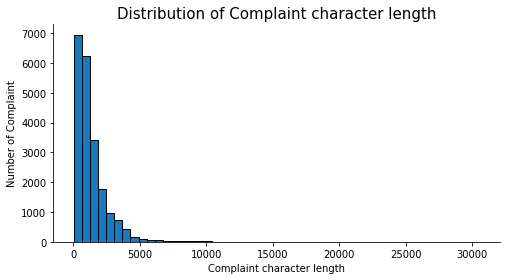

In [ ]:
# Create list of lengths of pre-processed complaints
doc_lens = [len(d) for d in df_clean['complaint']]
doc_lens[:5]

# Plot the data according to character length of complaints
plt.figure(figsize=(8,4))
plt.hist(doc_lens, edgecolor='black', bins = 50)
plt.title('Distribution of Complaint character length', fontsize=15)
plt.ylabel('Number of Complaint', fontsize=10)
plt.xlabel('Complaint character length', fontsize=10)
sns.despine()
plt.show()

In [ ]:
print('Maximum original text length: ', max(doc_lens))

Maximum original text length:  30545


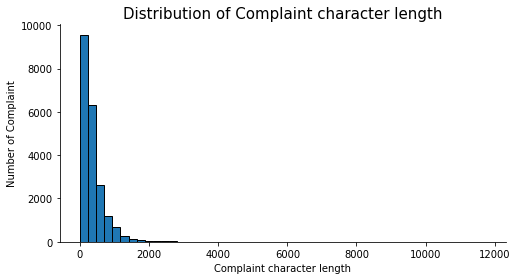

In [ ]:
# Create list of lengths of pre-processed complaints
doc_lens = [len(d) for d in df_clean['complaint_POS_removed']]
doc_lens[:5]

# Plot the data according to character length of complaints
plt.figure(figsize=(8,4))
plt.hist(doc_lens, edgecolor='black', bins = 50)
plt.title('Distribution of Complaint character length', fontsize=15)
plt.ylabel('Number of Complaint', fontsize=10)
plt.xlabel('Complaint character length', fontsize=10)
sns.despine()
plt.show()

In [ ]:
print('Maximum processed text length: ', max(doc_lens))

Maximum processed text length:  11737


We can see that most of the original complaints' texts have a word length less than 5,000 and maximum is 30,545 (a big number!). After processing the text most lengths are less than 2,000 and maximum is 11,737 (still a big number!).

**In original texts we have ~60% of words that are not nouns**, which means that they are not representative of the document intention.

This is why it is so important to clean the text.

For following analysis **we'll use column after POS tagging**, as it does not have the masked personal information (words with X characters only).

### Top 40 words by frequency 
Among all the articles after processing the text.

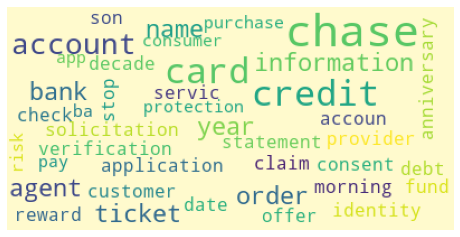

In [ ]:
# Using a word cloud, we plot the top 40 words by frequency among all the articles after processing the text
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='lemonchiffon',
                          stopwords=stopwords,
                          max_words=40,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(8,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

We are able to see that **words such as *card*, *chase*, *name*, *complaint*, *account*, and *credit* are the top used words**. This is expected as we are analyzing customer complaints.

In which scenarios are these words used? In general **we'd like to know the most common compositions of words** that the complaints have so we can further analyze them and assign a category.

### Top unigrams, bigrams and trigrams
Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [ ]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [ ]:
# Function to get top n words from corpus
def get_top_ngrams(corpus, n=None, ngram_range=1):
    """
    This function takes a corpus of words (text) and returns the top n grams 
    among the words in the corpus according to their frequency of occurence.
    :param corpus: input text
    :param n: number of top words(unigrams) to find
    :param ngram_range: range of words to consider (unigram=1, bigram=2, trigram=3)
    :return: list of tuples with two elements each: the word and its frequency
    """
    vec = CountVectorizer(stop_words='english',ngram_range=(ngram_range,ngram_range)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


#### Top unigrams by frequency
Among all the complaints.

These should be aligned to most common words we were able to see in word cloud, as we are only taking 1 by frequency word into account.

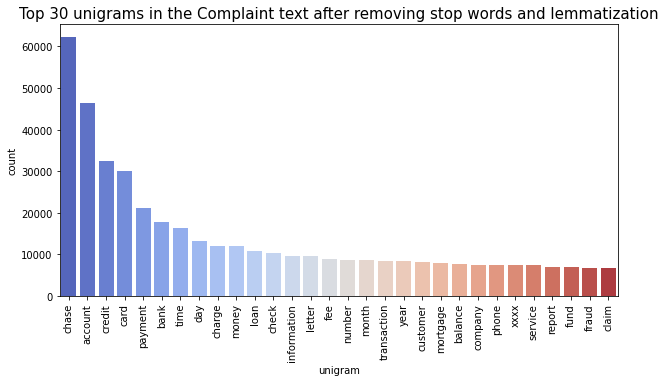

In [ ]:
# Top 30 unigrams by frequency among all the complaints
common_words = get_top_ngrams(df_clean['complaint_POS_removed'].values.astype('U'), 30, 1)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

# Plot the top 30 unigrams
plt.figure(figsize=(10,5))
sns.barplot(x='unigram', y='count', data=df2, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 unigrams in the Complaint text after removing stop words and lemmatization", fontsize=15)
plt.show()

In [ ]:
# Print the top 10 words in the unigram frequence
df2.head(10)

,unigram,count
0,chase,62197
1,account,46420
2,credit,32348
3,card,29969
4,payment,21217
5,bank,17905
6,time,16281
7,day,13149
8,charge,12114
9,money,11998


As expected, we are aligned with findings in Word Cloud. All words related to bank accounts.

#### Top bigrams by frequency
Now we'll augment the number of words to consider (phrases) and see the most common bigrams in the complaints.

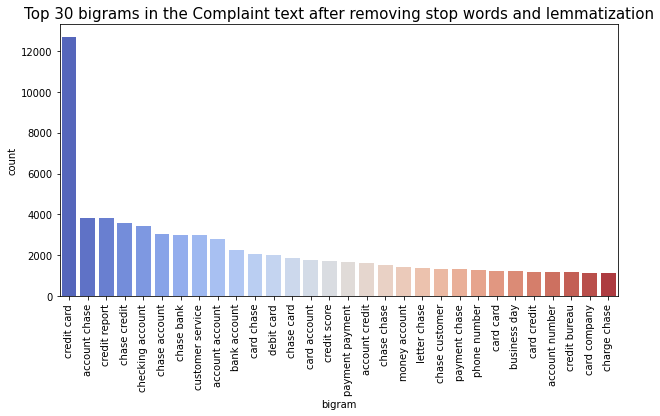

In [ ]:
common_words = get_top_ngrams(df_clean['complaint_POS_removed'].values.astype('U'), 30, 2)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

# Plot the top 30 bigrams
plt.figure(figsize=(10,5))
sns.barplot(x='bigram', y='count', data=df3, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 bigrams in the Complaint text after removing stop words and lemmatization", fontsize=15)
plt.show()

In [ ]:
#Print the top 10 words in the bigram frequency
df3.head(10)

,bigram,count
0,credit card,12662
1,account chase,3822
2,credit report,3812
3,chase credit,3566
4,checking account,3441
5,chase account,3058
6,chase bank,2989
7,customer service,2970
8,account account,2779
9,bank account,2255


Most common bigrams are related to credits and accounts, which is again expected.

#### Top trigrams by frequency

Let's augment the number of words to consider again.

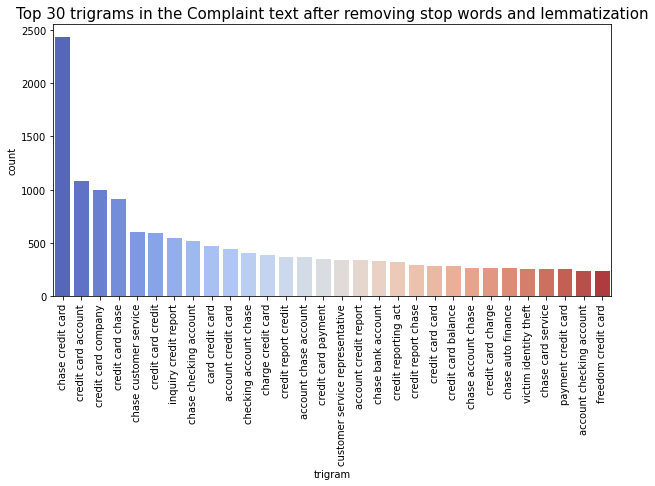

In [ ]:
common_words = get_top_ngrams(df_clean['complaint_POS_removed'].values.astype('U'), 30, 3)
df4 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

# Plot the top 30 unigrams
plt.figure(figsize=(10,5))
sns.barplot(x='trigram', y='count', data=df4, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the Complaint text after removing stop words and lemmatization", fontsize=15)
plt.show()

In [ ]:
#Print the top 10 words in the trigram frequency
df4.head(10)

,trigram,count
0,chase credit card,2431
1,credit card account,1083
2,credit card company,998
3,credit card chase,908
4,chase customer service,603
5,credit card credit,588
6,inquiry credit report,547
7,chase checking account,515
8,card credit card,467
9,account credit card,445


Now we see that **most of the complaints are about credits!**

### Personal details handling
The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis.

Also, from our cleaning step we have "XX" words that were part of dates, we'll remove those also.

Note that **this information did not appear in POS tagging**, it was not recognized as a noun.

In [ ]:
# Remove X character words
df_clean['complaint'] = df_clean['complaint'].str.lower().str.replace('xx+','',regex=True)
df_clean['lemmatized'] = df_clean['lemmatized'].str.lower().str.replace('xx+','',regex=True)

Let's check we have removed all masked texts correctly.

In [ ]:
# All masked texts have been removed
df_clean

,complaint,lemmatized,complaint_POS_removed,Complaint_clean
0,good morning my name is and i appreciate it ...,good morning my name is and i appreciate it ...,morning name stop debt verification statement ...,morning name stop debt verification statement ...
1,i upgraded my card in and was told by the ...,i upgraded my card in and wa told by the a...,agent anniversary date agent information order...,agent anniversary date agent information order...
2,chase card was reported on however fraudulen...,chase card wa reported on however fraudulent...,chase card application identity consent servic...,chase card application identity consent servic...
3,on while trying to book a ticket i came ac...,on while trying to book a ticket i came ac...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...
...,...,...,...,...
21067,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
21068,on wednesday i called chas my visa credit...,on wednesday i called chas my visa credit...,credit card provider claim purchase protection...,credit card provider claim purchase protection...
21069,i am not familiar with pay and did not unders...,i am not familiar with pay and did not unders...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...
21070,i have had flawless credit for yrs i ve had ch...,i have had flawless credit for yr i ve had cha...,credit yr chase credit card chase freedom prob...,credit yr chase credit card chase freedom prob...


## Feature Extraction
To perform feature extraction we must convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix 
Using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['complaint'])

## Topic Modelling 
Using NMF.

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you we'll perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [ ]:
from sklearn.decomposition import NMF

We need to take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

**We'll start with 5 as those are the total objective categories in this case study.**

In [ ]:
# Load your nmf_model with the n_components i.e 5
num_topics = 5

# keep the random_state =40
nmf_model = NMF(random_state=40, n_components=num_topics)

In [ ]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

14971

We have obtained **14,971 features.**

### Topic word distribution
To see if we can assign a topic for each row.

In [ ]:
# Print the Top 15 words for each of the topics
words = np.array(tfidf.get_feature_names())
topic_words_df = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = nmf_model.components_[i].argsort()[::-1][:15]
    topic_words_df.iloc[i] = words[ix]

topic_words_df

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,card,chase,charges,charge,dispute,fraud,called,received,did,told,merchant,claim,transaction,said,refund
Topic 2,credit,card,report,inquiry,chase,inquiries,hard,cards,reporting,score,accounts,account,closed,debt,removed
Topic 3,loan,mortgage,chase,home,modification,property,foreclosure,payments,house,bank,years,sale,morgan,rate,jp
Topic 4,account,bank,check,chase,money,funds,checking,closed,deposit,branch,told,accounts,deposited,said,business
Topic 5,payment,late,payments,balance,paid,pay,month,fees,fee,statement,auto,account,chase,charged,monthly


Analyzing above words we see that:

- *Topic 1* is about frauds/disputes.
- *Topic 2* is about credit cards.
- *Topic 3* is about mortgages.
- *Topic 4* is about bank account services.
- *Topic 5* is about fees and payments.

In [ ]:
# Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)
topic_results.argmax(axis=1)

array([2, 0, 1, ..., 0, 4, 4])

In [ ]:
# Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_results.argmax(axis=1)

In [ ]:
df_clean[['complaint','Topic']].head()

,complaint,Topic
0,good morning my name is and i appreciate it ...,2
1,i upgraded my card in and was told by the ...,0
2,chase card was reported on however fraudulen...,1
3,on while trying to book a ticket i came ac...,1
4,my grand son give me check for i deposit it in...,3


Now let's print the first 5 complaints for each of the topics to check if they have been assigned correctly.

In [ ]:
# Print the first 5 Complaint for each of the Topics
df_clean_topic = df_clean[['complaint','Topic']].groupby('Topic').head(5)
df_clean_topic[['complaint','Topic']].sort_values('Topic')

,complaint,Topic
1,i upgraded my card in and was told by the ...,0
8,on i made a payment to an online retailer u...,0
18,chase sent me an email today with the innocuou...,0
16,a sofa love seat table and chairs and was ne...,0
14,my chase amazon card was declined for a cateri...,0
2,chase card was reported on however fraudulen...,1
3,on while trying to book a ticket i came ac...,1
5,can you please remove inquiry,1
9,i have a chase credit card which is incorrectl...,1
11,i have reached out to several times in attemp...,1


### Topic assignment
We saw most of the topics have been correctly assigned.
We'll assign now a name.
* Topic 4: Bank Account services
* Topic 2: Credit card or prepaid card
* Topic 1: Theft/Dispute Reporting
* Topic 3: Mortgage/Loan
* Topic 5: Others

In [ ]:
#Create the dictionary of Topic names and Topics
Topic_names = {
    0: 'Theft/Dispute reporting',
    1: 'Credit card or prepaid card',
    2: 'Mortgage/Loan',
    3: 'Bank Account services',
    4: 'Others'
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean[['complaint','Topic']]

,complaint,Topic
0,good morning my name is and i appreciate it ...,Mortgage/Loan
1,i upgraded my card in and was told by the ...,Theft/Dispute reporting
2,chase card was reported on however fraudulen...,Credit card or prepaid card
3,on while trying to book a ticket i came ac...,Credit card or prepaid card
4,my grand son give me check for i deposit it in...,Bank Account services
...,...,...
21067,after being a chase card customer for well ove...,Credit card or prepaid card
21068,on wednesday i called chas my visa credit...,Theft/Dispute reporting
21069,i am not familiar with pay and did not unders...,Theft/Dispute reporting
21070,i have had flawless credit for yrs i ve had ch...,Others


## Model building using supervised learning
Of a supervised model to predict a complaint topic.

We'll build the model to create the topics for each complaint. Now in the below section we will use them to classify any new complaints.

Since we will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers).

In [ ]:
# Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['complaint','Topic']].copy()

In [ ]:
training_data

,complaint,Topic
0,good morning my name is and i appreciate it ...,Mortgage/Loan
1,i upgraded my card in and was told by the ...,Theft/Dispute reporting
2,chase card was reported on however fraudulen...,Credit card or prepaid card
3,on while trying to book a ticket i came ac...,Credit card or prepaid card
4,my grand son give me check for i deposit it in...,Bank Account services
...,...,...
21067,after being a chase card customer for well ove...,Credit card or prepaid card
21068,on wednesday i called chas my visa credit...,Theft/Dispute reporting
21069,i am not familiar with pay and did not unders...,Theft/Dispute reporting
21070,i have had flawless credit for yrs i ve had ch...,Others


### Create Vector count

In [ ]:
# Code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data['complaint'])

### Transform Word vector to TF-IDF

In [ ]:
# Transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

### Define train and test datasets

We'll save 25% of data for testing.

In [ ]:
# Libraries for evaluating models
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [ ]:
# Perform Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (15804, 27685)
Shape of y_train: (15804,)
Shape of X_test: (5268, 27685)
Shape of y_test: (5268,)


### Define a function to evaluate models

In [ ]:
# Libraries for machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [ ]:
# Create a function to evaluate models
def eval_model(y_test, y_pred, model_name):
    """
    This function prints the classification report of a classifier 
    and plots the confusion martrix
    :param y_test: actual labels
    :param y_pred: predicted labels
    :param model_name: the name of the model being evaluated
    :return: None
    """
    
    # print classification report of classifier
    print(f"CLASSIFICATION REPORT for {model_name}\n")
    print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"]))
    
    # plot confusion matrix of the classifier
    plt.figure(figsize=(8,5))
    plt.title(f"CONFUSION MATRIX for {model_name}\n")
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, cbar=None, cmap="Blues", fmt='d', xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"])
    plt.show()
    
    return

### Evaluate Logistic Regression model

In [ ]:
# Run the Logistic Regression model
model_name = 'LOGISTIC REGRESSION'
clf_lr = LogisticRegression(solver='liblinear')
%time 
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


We'll **calculate the F1-score** as we'll compare the model against others.

In [ ]:
# Calculate F1 Score using weighted average method
f1_lr = f1_score(y_test, y_pred_lr, average="weighted")
f1_lr

0.9449881481290232

We obtained a great F1-score of ~94.5%, let's see if we can improve it by **tuning the hyperparameters**.

In [ ]:
# Hyperparameter tuning to improve Logistic Regression performance
param_grid_lr = {
     'penalty': ['l1', 'l2','elasticnet', 'none'],
     'C': [0.001,0.01,0.1,1,10,100],
     'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_lr = GridSearchCV(estimator=clf_lr, 
                        param_grid=param_grid_lr,
                        verbose=1,
                        scoring='f1_weighted',
                        n_jobs=-1,
                        cv=5)
grid_lr.fit(X_train, y_train)
print(grid_lr.best_params_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
{'C': 10, 'penalty': 'l1', 'solver': 'saga'}


In [ ]:
# Run Logistic Regression on tuned hyperparameters
clf_lr_tuned = LogisticRegression(C=1, 
                                  penalty='l1',
                                  solver='saga'
                                  )
%time 
clf_lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = clf_lr_tuned.predict(X_test)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


Let's check the F1-score again.

In [ ]:
# Calculate F1 Score of tuned model using weighted average method
f1_lr_tuned = f1_score(y_test, y_pred_lr_tuned, average="weighted")
f1_lr_tuned

0.9544596133238696

We were able to improve the results by 1%, obtaining ~95.5%.

Let's check also **precision, recall and support metrics**, and take a look at the **confusion matrix**.

CLASSIFICATION REPORT for LOGISTIC REGRESSION

                             precision    recall  f1-score   support

      Bank Account services       0.95      0.96      0.96      1402
Credit card or prepaid card       0.96      0.96      0.96      1099
                     Others       0.97      0.95      0.96       924
    Theft/Dispute Reporting       0.96      0.95      0.95       653
              Mortgage/Loan       0.94      0.94      0.94      1190

                   accuracy                           0.95      5268
                  macro avg       0.96      0.95      0.95      5268
               weighted avg       0.95      0.95      0.95      5268



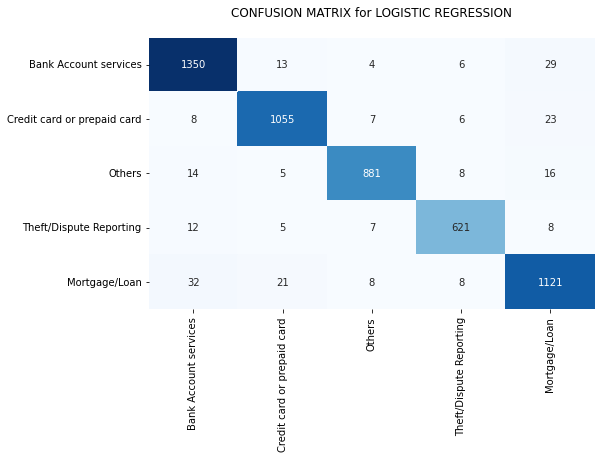

In [ ]:
# Evaluate the tuned Logistic Regression classifier
eval_model(y_test, y_pred_lr_tuned, model_name)

### Evaluate Decision Tree model

In [ ]:
model_name = 'DECISION TREE'
clf_dt = DecisionTreeClassifier()
%time 
clf_dt.fit(X_train, y_train)
y_pred_dt = clf_dt.predict(X_test)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


We'll **calculate the F1-score** as we'll compare the model against others.

In [ ]:
# Calculate F1 Score using weighted average method
f1_dt = f1_score(y_test, y_pred_dt, average="weighted")
f1_dt

0.7640004214233025

We obtained a great F1-score of ~76%, let's see if we can improve it by **tuning the hyperparameters**.

In [ ]:
# Hyperparameter tuning to improve Decision Tree performance
param_grid_dt = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ['gini', 'entropy']
}

grid_dt = GridSearchCV(estimator=clf_dt, 
                        param_grid=param_grid_dt,
                        verbose=1,
                        scoring='f1_weighted',
                        n_jobs=-1,
                        cv=5)
grid_dt.fit(X_train, y_train)
print(grid_dt.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 20}


In [ ]:
# Run Decision Tree on tuned hyperparameters
clf_dt_tuned = DecisionTreeClassifier(max_depth=20, 
                                      min_samples_leaf=20,
                                      criterion='gini'
                                  )
%time 
clf_dt_tuned.fit(X_train, y_train)
y_pred_dt_tuned = clf_dt_tuned.predict(X_test)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


Let's check the F1-score again.

In [ ]:
# Calculate F1 Score of tuned model using weighted average method
f1_dt_tuned = f1_score(y_test, y_pred_dt_tuned, average="weighted")
f1_dt_tuned

0.7920053079938615

We were able to improve the results, obtaining ~79%.

Let's check also **precision, recall and support metrics**, and take a look at the **confusion matrix**.

CLASSIFICATION REPORT for DECISION TREE

                             precision    recall  f1-score   support

      Bank Account services       0.80      0.85      0.82      1402
Credit card or prepaid card       0.82      0.82      0.82      1099
                     Others       0.86      0.79      0.83       924
    Theft/Dispute Reporting       0.78      0.68      0.73       653
              Mortgage/Loan       0.72      0.76      0.74      1190

                   accuracy                           0.79      5268
                  macro avg       0.80      0.78      0.79      5268
               weighted avg       0.79      0.79      0.79      5268



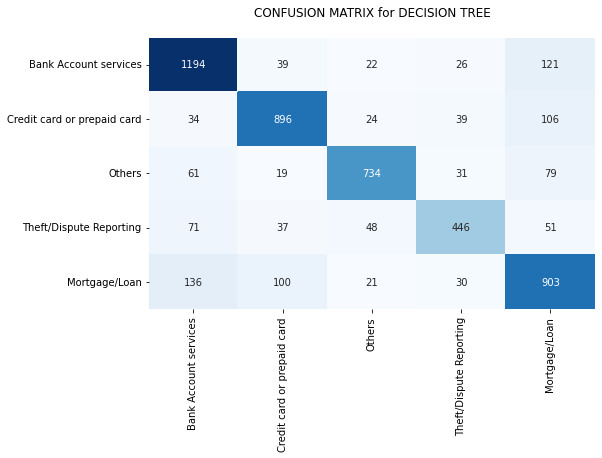

In [ ]:
# Evaluate the tuned Decision Tree classifier
eval_model(y_test, y_pred_dt_tuned, model_name)

### Evaluate Random Forest model

In [ ]:
model_name = 'RANDOM FOREST'
clf_rf = RandomForestClassifier()
%time 
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


We'll **calculate the F1-score** as we'll compare the model against others.

In [ ]:
# Calculate F1 Score using weighted average method
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")
f1_rf

0.8374950999329333

In [ ]:
# # Hyperparameter tuning to improve Random Forest performance
param_grid_rf = {
     'n_estimators': [100, 200, 300, 500, 800],
     'criterion':['gini','entropy'],
     'max_depth': [10, 30, 40],
     'min_samples_split': [1, 5, 10],
     'min_samples_leaf': [1, 5, 10],
     'max_features': ['log2', 'sqrt', None]    
}

grid_rf = RandomizedSearchCV(estimator=clf_rf, 
                        param_distributions=param_grid_rf,
                        scoring='f1_weighted',
                        verbose=1,
                        n_jobs=-1,
                        cv=5)
grid_rf.fit(X_train, y_train)
print(grid_rf.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 40, 'criterion': 'gini'}


In [ ]:
# Run Random Forest on tuned hyperparameters
clf_rf_tuned = RandomForestClassifier(n_estimators=100, 
                                      min_samples_split=5, 
                                      min_samples_leaf=1, 
                                      max_features=None, 
                                      max_depth=40, 
                                      criterion='gini'
)
%time 
clf_rf_tuned.fit(X_train, y_train)
y_pred_rf_tuned = clf_rf_tuned.predict(X_test)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


We obtained a great F1-score of ~84%.

To keep this task simple we won't tune the parameters.

Let's check also **precision, recall and support metrics**, and take a look at the **confusion matrix**.

CLASSIFICATION REPORT for RANDOM FOREST

                             precision    recall  f1-score   support

      Bank Account services       0.78      0.95      0.86      1402
Credit card or prepaid card       0.84      0.86      0.85      1099
                     Others       0.89      0.89      0.89       924
    Theft/Dispute Reporting       0.94      0.55      0.69       653
              Mortgage/Loan       0.86      0.82      0.84      1190

                   accuracy                           0.84      5268
                  macro avg       0.86      0.81      0.83      5268
               weighted avg       0.85      0.84      0.84      5268



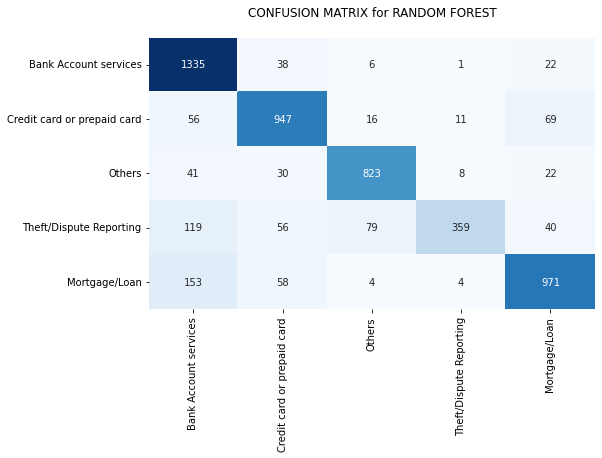

In [ ]:
model_name = 'RANDOM FOREST'
# Evaluate the tuned Decision Tree classifier
eval_model(y_test, y_pred_rf, model_name)

### Evaluate Naive Bayes model

In [ ]:
# Run the Naive Bayes model
model_name = 'NAIVE BAYES'
clf_nb = MultinomialNB()
%time 
clf_nb.fit(X_train, y_train)
y_pred_nb = clf_nb.predict(X_test)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


We'll **calculate the F1-score** as we'll compare the model against others.

In [ ]:
# Calculate F1 Score using weighted average method
f1_lr = f1_score(y_test, y_pred_nb, average="weighted")
f1_lr

0.6898606381241196

In [ ]:
# # Hyperparameter tuning to improve Naive Bayes performance
param_grid_nb = {
     'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
     'fit_prior':[True, False]
}

grid_nb = GridSearchCV(estimator=clf_nb, 
                        param_grid=param_grid_nb,
                        verbose=1,
                        scoring='f1_weighted',
                        n_jobs=-1,
                        cv=10)
grid_nb.fit(X_train, y_train)
print(grid_nb.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
{'alpha': 0.1, 'fit_prior': False}


In [ ]:
# Run Multinomial Naive Bayes on tuned hyperparameters
clf_nb_tuned = MultinomialNB(alpha=0.1, fit_prior=False)
%time 
clf_nb_tuned.fit(X_train, y_train)
y_pred_nb_tuned = clf_nb_tuned.predict(X_test)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [ ]:
# Calculate F1 Score of tuned model using weighted average method
f1_nb_tuned = f1_score(y_test, y_pred_nb_tuned, average="weighted")
f1_nb_tuned

0.8035591660758139

In [ ]:
# Evaluate the tuned Naive Bayes classifier
eval_model(y_test, y_pred_nb_tuned, model_name

We obtained an F1-score of ~69%, which has been the lowest one.

Hyperparameter tuning is not a valid method to improve Naive Bayes classifier accuracy. 

Like all machine learning algorithms, we can boost the Naive Bayes classifier by applying some simple techniques to the dataset, like data preprocessing and feature selection, but in this case we have a very simple dataset so we'll keep this basic model with default library values.

Let's check also **precision, recall and support metrics**, and take a look at the **confusion matrix**.

CLASSIFICATION REPORT for RANDOM FOREST

                             precision    recall  f1-score   support

      Bank Account services       0.57      0.96      0.71      1402
Credit card or prepaid card       0.82      0.68      0.74      1099
                     Others       0.88      0.80      0.84       924
    Theft/Dispute Reporting       0.98      0.13      0.24       653
              Mortgage/Loan       0.80      0.70      0.75      1190

                   accuracy                           0.71      5268
                  macro avg       0.81      0.66      0.66      5268
               weighted avg       0.78      0.71      0.69      5268



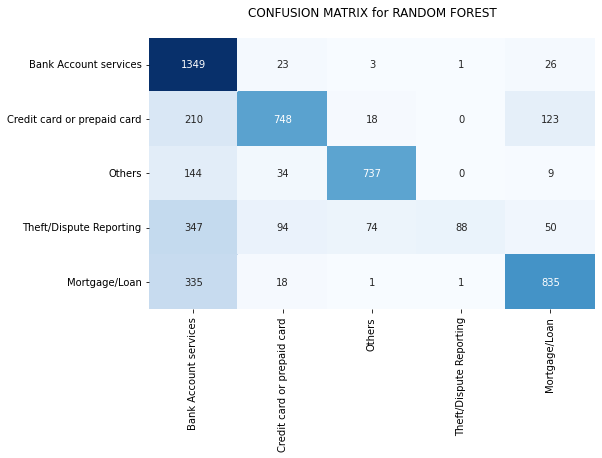

In [ ]:
# Evaluate the tuned Logistic Regression classifier
eval_model(y_test, y_pred_nb, model_name)

Model #5: Support Vector Machine

In [ ]:
from sklearn.svm import SVC

# Run the Support Vector Machine (SVM) model on default hyperparameters
model_name = 'SUPPORT VECTOR MACHINE'
clf_svm = SVC()
%time 
clf_svm.fit(X_train, y_train)
y_pred_svm = clf_svm.predict(X_test)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


In [ ]:
# Calculate F1 Score using weighted average method
f1_svm = f1_score(y_test, y_pred_svm, average="weighted")
f1_svm

0.9381248087813858

In [ ]:
# # Hyperparameter tuning to improve SVM performance
param_grid_svm = {
     'C': [10, 15],
     'gamma': ['scale', 0.01],
     'kernel': ['linear', 'rbf']
}

grid_svm = GridSearchCV(estimator=clf_svm, 
                        param_grid=param_grid_svm,
                        scoring='f1_weighted',
                        verbose=1,
                        n_jobs=-1,
                        cv=2)
grid_svm.fit(X_train, y_train)
print(grid_svm.best_params_)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
{'C': 15, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
# Run SVM on tuned hyperparameters
clf_svm_tuned = SVC(C=15,
                    gamma='scale',
                    kernel='rbf')
%time 
clf_svm_tuned.fit(X_train, y_train)
y_pred_svm_tuned = clf_svm_tuned.predict(X_test)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


In [ ]:
# Calculate F1 Score of tuned model using weighted average method
f1_svm_tuned = f1_score(y_test, y_pred_svm_tuned, average="weighted")
f1_svm_tuned

0.940657259833581

### Evaluate SVM Model

CLASSIFICATION REPORT for SUPPORT VECTOR MACHINE

                             precision    recall  f1-score   support

      Bank Account services       0.94      0.96      0.95      1402
Credit card or prepaid card       0.95      0.94      0.94      1099
                     Others       0.95      0.94      0.95       924
    Theft/Dispute Reporting       0.94      0.89      0.91       653
              Mortgage/Loan       0.93      0.95      0.94      1190

                   accuracy                           0.94      5268
                  macro avg       0.94      0.93      0.94      5268
               weighted avg       0.94      0.94      0.94      5268



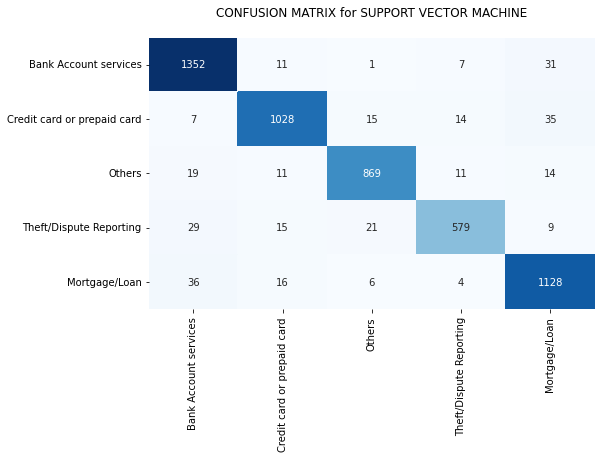

In [ ]:
# Evaluate the SVM classifier
eval_model(y_test, y_pred_svm_tuned, model_name)


### Model selection

Let's take a look into a summary of models' metrics.

| Model | Precision | Recall | F1-score |
| --- | --- | --- | --- |
| Logistic Regression | 0.95 | 0.95 | 0.95 |
| Decision Tree | 0.78 | .77 | 0.77 |
| Random Forest | 0.85 | 0.84 | 0.84 |
| Naive Bayes | 0.78 | 0.71 | 0.69 |
| SVM | 0.94 | 0.94 | 0.94 |

**Logistic Regression** has the best performance with 95% of precision, recall, and F1-score.

We'll use the tuned model version for predicting and then evaluate its performance.

## Model inference
We'll apply the best model to predict a custom text to see its performance. 

We created custom complaints that fit one of the topics, in order.
- Topic 1: 'Theft/Dispute reporting',
- Topic 2: 'Credit card or prepaid card',
- Topic 3: 'Mortgage/Loan',
- Topic 4: 'Bank Account services',
- Topic 5: 'Others'

In [ ]:
# Some sample complaints to infer model
df_complaints = pd.DataFrame({'complaint': [
                                  "I received a fraudulent email about a merchant saying a dispute with me is open and requested some information.",
                                  "Last credit card report shown a duplicated charge. Please take a look into it.",
                                  "I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
                                  "I want to open a bank account at the nearest location with initial funds. Please provide me the procedure.",
                                  "What are the different ways I can make payments?"]})
df_complaints

,complaint
0,I received a fraudulent email about a merchant...
1,Last credit card report shown a duplicated cha...
2,I can not get from chase who services my mortg...
3,I want to open a bank account at the nearest l...
4,What are the different ways I can make payments?


Let's define a function to predict by using the best selected model, that in this case is the Tuned Logistic Regression one.

In [ ]:
def predict_best_model(text):
    """
    This function applies required transformations to given text to use best 
    model and predict its topic
    :param text: input text
    """
    X_new_counts = count_vect.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = clf_lr_tuned.predict(X_new_tfidf)
    return predicted[0]

Let's **predict the topics of our custom complaints**.

In [ ]:
df_complaints['Topic'] = df_complaints['complaint'].apply(lambda x: predict_best_model([x]))
df_complaints

,complaint,Topic
0,I received a fraudulent email about a merchant...,Theft/Dispute reporting
1,Last credit card report shown a duplicated cha...,Credit card or prepaid card
2,I can not get from chase who services my mortg...,Mortgage/Loan
3,I want to open a bank account at the nearest l...,Bank Account services
4,What are the different ways I can make payments?,Others


Model has been able to **correctly predict the topic of the custom complaints.**

## Conclusions

We were **able to classify complaints into the following five topics** based on their content:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 

**We tested N different supervised models** with following results:

| Model | Precision | Recall | F1-score |
| --- | --- | --- | --- |
| Logistic Regression | 0.95 | 0.95 | 0.95 |
| Decision Tree | 0.78 | .77 | 0.77 |
| Random Forest | 0.85 | 0.84 | 0.84 |
| Naive Bayes | 0.78 | 0.71 | 0.69 |
| SVM | 0.94 | 0.94 | 0.94 |

**Logistic Regression has highest accuracy of 95%**, and that makes it a good fit for this case study.